##### 0. Import libraries

In [3]:
!pip install wfdb matplotlib numpy pandas scikit-learn shap tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 27.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [4]:
import wfdb
import matplotlib.pyplot as plt
import os
import wfdb
import numpy as np
import pandas as pd
from scipy.stats import entropy
from scipy.signal import find_peaks, welch
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. **FEATURES EXTRACTION**

The first step in our code is to extract features from out data to be able to train our model. To do this, we use the ECG signals from the MIT-BIH Database to extract features from every heart beat. This features are numerical values that describe how is every beat.

So, we will extract this list of features:

- **RR Interval**: Time between one beat and the next one (it indicates heart rate)
- **RR Previous**: Time between current beat and the previous one
- **ΔRR**: Variation between the two RR (measures rhythm variability. An irregular rhythm (as in atrial fibrillation) has large ΔRR values.)
- **QRS Amplitude**: Maximum value of QRS (indicates the strength of contraction). A high QRS may indicate a strong contraction; a low QRS may indicate electrical problems.
- **Energy**: Energy of the beat (measures overall intensity. We add the square of all the signal values: this measures the total energy. A signal with a lot of activity (or noise) will have more energy.)
- **Dominant Frequency**: The strongest frequency of the beat (FFT) (helps detect unusual rhythms. We use Fourier transform to see which frequency is strongest in the heartbeat. Arrhythmias sometimes have different frequency components than normal heartbeats.)
- **Derivative 1 and 2**: Speed ​​and acceleration of signal change (provides information about the shape. Derivative 1 = how the signal changes; tells you whether the signal rises/falls quickly or slowly. Derivative 2 = how the speed changes. It gives information about the shape of the QRS, especially in abnormal heartbeats.)
- **Entropy**: Measures how ordered or chaotic the signal is (useful for detecting irregularities. High entropy = more disorder; may indicate chaotic or pathological rhythm.)
- **QRS Width**: Duration of the QRS (if it is very wide, it may indicate blockages or arrhythmias)

In [ ]:
# Path where the ECG files are located
data_path = "/Volumes/TFG/TFM/data/"

# Get the list of available records (without extensions)
records = [f.split(".")[0] for f in os.listdir(data_path) if f.endswith(".dat")]
records = list(set(records))  # Remove duplicates

# List to store data
ecg_data = []

# Define analysis window (in samples)
window_size = 50  # 50 samples around the beat (~140ms)

# Iterate through all records
for record in records:
    try:
        print(f"Processing: {record}...")

        # Read the ECG signal
        record_data = wfdb.rdrecord(os.path.join(data_path, record))
        annotation = wfdb.rdann(os.path.join(data_path, record), "atr")

        # Get the signal (MLII)
        signal = record_data.p_signal[:, 0]  # Use the first lead
        fs = record_data.fs  # Sampling frequency (360 Hz)

        # Extract beat information
        for i in range(1, len(annotation.sample) - 1):
            beat_time = annotation.sample[i]
            prev_beat_time = annotation.sample[i - 1]
            next_beat_time = annotation.sample[i + 1]

            # Calculate RR intervals (current, previous, next)
            rr_interval = (next_beat_time - beat_time) / fs  # in seconds
            rr_prev = (beat_time - prev_beat_time) / fs  # Previous RR
            delta_rr = rr_interval - rr_prev  # RR variability

            # Extract QRS amplitude
            qrs_amplitude = signal[beat_time] if beat_time < len(signal) else np.nan

            # Extract signal window for analysis
            start = max(0, beat_time - window_size // 2)
            end = min(len(signal), beat_time + window_size // 2)
            beat_window = signal[start:end]

            # Calculate signal energy
            energy = np.sum(beat_window ** 2)

            # Calculate dominant frequency of the beat
            freqs, power = welch(beat_window, fs=fs, nperseg=len(beat_window))
            dominant_freq = freqs[np.argmax(power)] if len(freqs) > 0 else np.nan

            # Calculate signal derivatives
            deriv1 = np.mean(np.diff(beat_window))  # First derivative
            deriv2 = np.mean(np.diff(np.diff(beat_window)))  # Second derivative

            # Calculate signal entropy
            prob_dist = np.histogram(beat_window, bins=10, density=True)[0] + 1e-6
            signal_entropy = entropy(prob_dist)

            # QRS width (distance between peaks)
            peaks, _ = find_peaks(beat_window, height=0.5 * np.max(beat_window))
            qrs_width = np.max(np.diff(peaks)) if len(peaks) > 1 else np.nan

            # Save data
            ecg_data.append([
                record, beat_time, rr_interval, rr_prev, delta_rr, qrs_amplitude,
                energy, dominant_freq, deriv1, deriv2, signal_entropy, qrs_width,
                annotation.symbol[i]
            ])

    except Exception as e:
        print(f"Error with {record}: {e}")

# Convert to DataFrame
columns = [
    "Record", "Beat Time", "RR Interval", "RR Previous", "ΔRR", "QRS Amplitude",
    "Energy", "Dominant Frequency", "Derivative 1", "Derivative 2", "Entropy",
    "QRS Width", "Label"
]
df = pd.DataFrame(ecg_data, columns=columns)

# Save to CSV
df.to_csv("ecg_features.csv", index=False)

print("Data saved to 'ecg_features.csv'")

# 2. **DATA PREPROCESSING**

After the features had been extracted from the original data, we have to do a preprocessing (cleansing and preparing the data) to ensure a proper input to the algorithm.

## 2.1. **AAMI based Classes Mapping**

First of all, we have to map the labels of our dataset with the AAMI (Association for the Advancement of Medical Instrumentation) standard, which defines five classes of beats: N (Normal), S (Supraventricular ectopic beats), V (Ventricular ectopic beats), F (Fusion beats) and Q (Unknown).

https://www.researchgate.net/figure/ECG-class-description-using-AAMI-standard_tbl1_342858593

https://www.researchgate.net/figure/ECG-signal-classification-standard-specified-by-ANSI-AAMI-EC57-and-the-number-of-each_tbl1_350458724

https://www.researchgate.net/publication/267411759_AN_X-RAY_ON_METHODS_AIMING_AT_ARRHYTHMIA_CLASSIFICATION_IN_ECG_SIGNALS#pf3

In [6]:
df = pd.read_csv("/content/drive/My Drive/TFM/ecg_features.csv")

In [7]:
# Define AAMI beat label mapping
AAMI_MAP = {
    'N': ['N', 'L', 'R', 'e', 'j'], # Normal
    'S': ['A', 'a', 'J', 'S'],      # Supraventricular ectopic
    'V': ['V', 'E'],                # Ventricular ectopic
    'F': ['F'],                     # Fusion
    'Q': ['/', 'f', 'Q']            # Unknown
}

# Function to map label to AAMI class
def map_label_to_aami(label):
    for aami_class, symbols in AAMI_MAP.items():
        if label in symbols:
            return aami_class
    return 'Q'  # Assign to Q (unknown/unclassifiable) by default

# Apply the mapping to the DataFrame
df['Class'] = df['Label'].apply(map_label_to_aami)


## 2.2. **Exploratory analysis**

To deep-dive in our data, we have to do an exploratory analysis. We will perform an a analysis of their distribution and correlation, adding as well visualizations.

#### **Original ECG dataset**

In [8]:
df.head()

,Record,Beat Time,RR Interval,RR Previous,ΔRR,QRS Amplitude,Energy,Dominant Frequency,Derivative 1,Derivative 2,Entropy,QRS Width,Label,Class
0,117,189,1.136111,0.325000,0.811111,-1.755,49.325350,14.4,0.002245,0.000208,1.935964,NaN,N,N
1,117,598,1.133333,1.136111,-0.002778,-1.665,48.460225,14.4,0.002653,0.000313,1.946429,NaN,N,N
2,117,1006,1.116667,1.133333,-0.016667,-1.860,63.866725,14.4,0.001531,-0.000313,1.766483,NaN,N,N
3,117,1408,1.183333,1.116667,0.066667,-1.475,45.182450,14.4,0.002959,-0.000313,1.839197,NaN,N,N
4,117,1834,1.152778,1.183333,-0.030556,-1.670,48.721150,14.4,0.002551,0.000000,1.926001,NaN,N,N


In the above table, we can see the first rows and the columns of our dataset after the feature extraction and the AAMI class mapping (*Label* is the column before the mapping, having as a result of it the *Class* column).

We have 14 columns (Reocrd, Beat Time, RR Interval, RR PRevious, ΔRR, Energy, Dominant Frequency, Derivative 1, Derivative 2, Entropy, QRS Width, Label and Class)

#### **Merge metadata and ECG dataframe**

In [10]:
metadata = pd.read_excel('/content/drive/My Drive/TFM/metadata_patients.xlsx')

# Convert 'Gender' to numeric (Male=1, Female=0)
metadata['Gender'] = metadata['Gender'].map({'Male': 1, 'Female': 0})

# Convert 'Medications (Y/N)' to binary (Y=1, N=0)
metadata['Medications (Y/N)'] = metadata['Medications (Y/N)'].map({'Y': 1, 'N': 0})

# Handle 'Age'
# Convert 'Age' to numeric (turn 'Unknown' to NaN)
metadata['Age'] = pd.to_numeric(metadata['Age'], errors='coerce')  # 'Unknown' becomes NaN
metadata['Age'] = metadata['Age'].fillna(metadata['Age'].mean())  # Replace NaN with the mean age

# Print first rows
print(metadata.head())

   Record  Gender        Age         Medications  Medications (Y/N)
0   100.0     1.0  69.000000    Aldomet, Inderal                1.0
1   101.0     0.0  75.000000             Diapres                1.0
2   102.0     0.0  84.000000             Digoxin                1.0
3   103.0     1.0  63.673913   Diapres, Xyloprim                1.0
4   104.0     0.0  66.000000  Digoxin, Pronestyl                1.0


As we can see in the table above, we have 5 columns: Record, Gender ('1' for Male and '0' for Female), Age, Medications, and Medications (Yes or No).

In [11]:
# Merge on 'Record' column
df_merged = df.merge(metadata, on='Record', how='left')

In [12]:
print(df_merged.head())
df = df_merged

   Record  Beat Time  RR Interval  RR Previous       ΔRR  QRS Amplitude  \
0     117        189     1.136111     0.325000  0.811111         -1.755   
1     117        598     1.133333     1.136111 -0.002778         -1.665   
2     117       1006     1.116667     1.133333 -0.016667         -1.860   
3     117       1408     1.183333     1.116667  0.066667         -1.475   
4     117       1834     1.152778     1.183333 -0.030556         -1.670   

      Energy  Dominant Frequency  Derivative 1  Derivative 2   Entropy  \
0  49.325350                14.4      0.002245      0.000208  1.935964   
1  48.460225                14.4      0.002653      0.000313  1.946429   
2  63.866725                14.4      0.001531     -0.000313  1.766483   
3  45.182450                14.4      0.002959     -0.000313  1.839197   
4  48.721150                14.4      0.002551      0.000000  1.926001   

   QRS Width Label Class  Gender   Age Medications  Medications (Y/N)  
0        NaN     N     N     1.0

The dataframe resulting of the merge is the metadata merged on column *Record* with the original ECG dataframe, so we have added new columns that will be more features to train the Machine Learning model after.

#### **Visualization: Beat distribution by Class**

Number of records:  48

--- Class Counts (AAMI) ---
F: 803 beats (0.71%)
N: 90589 beats (80.49%)
Q: 11144 beats (9.90%)
S: 2779 beats (2.47%)
V: 7236 beats (6.43%)


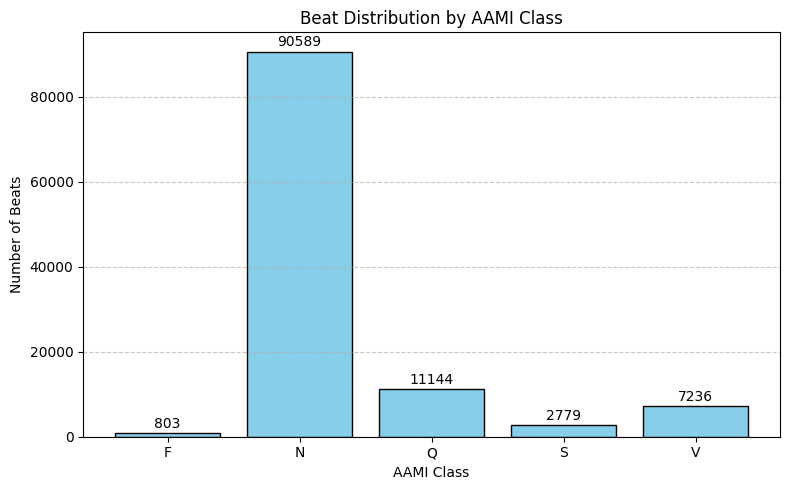

In [13]:
# Number of unique records (patients)
num_records = df['Record'].nunique()
print("Number of records: ", num_records)

# Class counts and percentages
class_counts = df['Class'].value_counts().sort_index()
total_beats = len(df)

print("\n--- Class Counts (AAMI) ---")
for cls, count in class_counts.items():
    percent = (count / total_beats) * 100
    print(f"{cls}: {count} beats ({percent:.2f}%)")

# Plot the class distribution
plt.figure(figsize=(8, 5))
bars = plt.bar(class_counts.index, class_counts.values, color='skyblue', edgecolor='black')
plt.title("Beat Distribution by AAMI Class")
plt.xlabel("AAMI Class")
plt.ylabel("Number of Beats")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 500, f"{int(yval)}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

In the *Beat Distribution by Class* graph, we can see a clearly unbalanced dataset, with a 80'49% of the quantity of beats classified as Normal, and less than a 20% distributed among the other four classes.

As a result of this, **we will have to balance the data**.

### 2.2.1. **OUTLIER HANDLING**

As a first step, we have to remove the outliers in our dataset to be able to visualize the data correctly and do a cleansing, having as a result a better data quality.

In [16]:
# Enhanced data preprocessing: handling outliers

# Function to detect and handle outliers using IQR method
def handle_outliers(df, columns):
    # Remove null values if any
    df.dropna(inplace=True)
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define outlier boundaries
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)][col]
        print(f"Found {len(outliers)} outliers in {col}")

        # Replace outliers with boundary values
        df_clean.loc[df_clean[col] < lower_bound, col] = lower_bound
        df_clean.loc[df_clean[col] > upper_bound, col] = upper_bound

    return df_clean

# Select numerical columns for outlier treatment
numerical_cols = ['RR Interval', 'RR Previous', 'ΔRR', 'QRS Amplitude',
                 'Energy', 'Dominant Frequency', 'Derivative 1',
                 'Derivative 2', 'Entropy', 'QRS Width']

# Apply outlier handling
df_clean = handle_outliers(df, numerical_cols)
df_clean.drop(columns=['Medications'], axis=1, inplace=True)

df_clean.head()

Found 26 outliers in RR Interval
Found 11 outliers in RR Previous
Found 830 outliers in ΔRR
Found 218 outliers in QRS Amplitude
Found 603 outliers in Energy
Found 268 outliers in Dominant Frequency
Found 436 outliers in Derivative 1
Found 533 outliers in Derivative 2
Found 217 outliers in Entropy
Found 198 outliers in QRS Width


,Record,Beat Time,RR Interval,RR Previous,ΔRR,QRS Amplitude,Energy,Dominant Frequency,Derivative 1,Derivative 2,Entropy,QRS Width,Label,Class,Gender,Age,Medications (Y/N)
1641,106,32450,0.602778,0.316667,0.286111,0.230,3.660350,7.2,-0.008163,-0.000208,2.126493,4.0,~,Q,0.0,24.0,1.0
1644,106,33045,1.197222,0.494444,0.443056,1.340,39.573950,7.2,-0.014184,-0.001562,2.154064,8.0,V,V,0.0,24.0,1.0
1653,106,35638,1.286111,0.472222,0.443056,1.390,31.509475,7.2,-0.011122,-0.000833,2.199050,7.0,V,V,0.0,24.0,1.0
1662,106,38267,1.355556,0.486111,0.443056,1.080,18.383625,7.2,-0.010000,-0.000417,2.251733,2.0,V,V,0.0,24.0,1.0
1665,106,39118,1.311111,0.497222,0.443056,1.175,24.036275,7.2,-0.010102,-0.000937,2.200531,9.0,V,V,0.0,24.0,1.0


Now, we have our dataset clean without outliers, which means we can visualize more clearly the distribution of our features.

#### **Features Distribution**

**RR Interval, QRS Amplitude, Energy and Entropy**

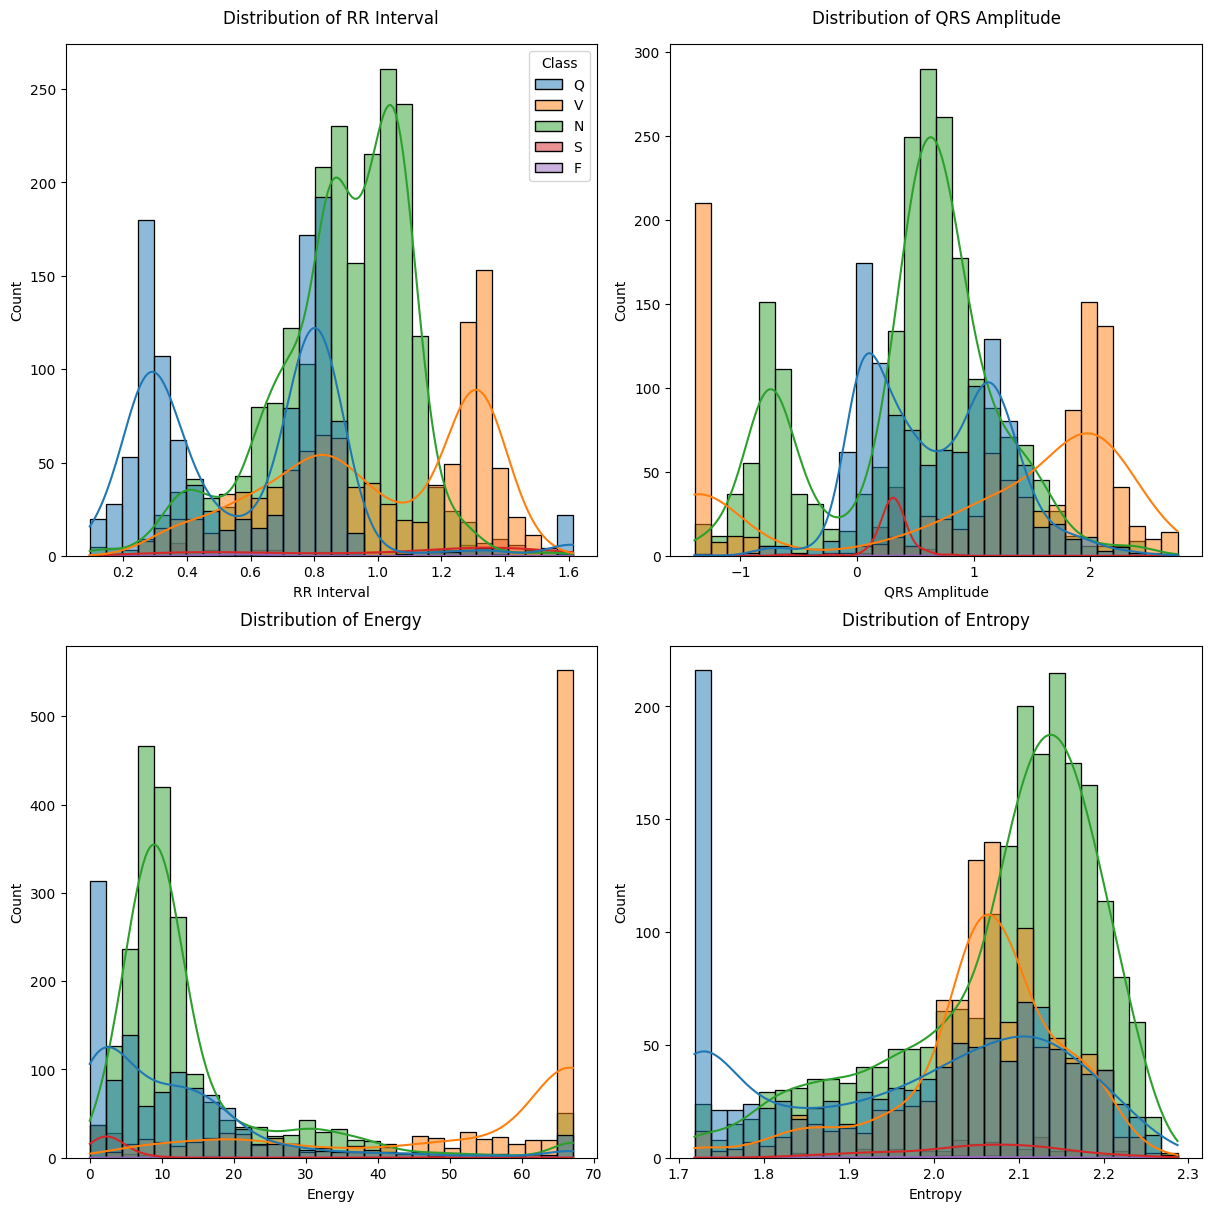

In [18]:
features = ["RR Interval", "QRS Amplitude", "Energy", "Entropy"]

fig, axes = plt.subplots(2, 2, figsize=(12, 12), constrained_layout=True)
axes = axes.flatten()

plt.sca(axes[0])
plot = sns.histplot(df_clean, x=features[0], hue="Class", kde=True, bins=30, legend=True)
plt.title(f"Distribution of {features[0]}", pad=15)
handles, labels = axes[0].get_legend_handles_labels()

for i in range(1, len(features)):
    plt.sca(axes[i])
    sns.histplot(df_clean, x=features[i], hue="Class", kde=True, bins=30, legend=False)
    plt.title(f"Distribution of {features[i]}", pad=15)

plt.show()

As we can see in the first graph (*RR Interval*), the Normal beats distribution is more centered (between 0.6 and 1.2) and the other beat types have diverse distributions, as Ventricular beats, that are biased to the bigger values.

In the second case, when analyzing the *QRS Amplitude*, the Normal and Q beats have their most beats quantity between the centered values of the X axis, but the Normal ones reach higher values (having a maximum of more than 250).

In the third case, *Distribution of Energy*, all values are biased towards the extremes of the X axis of the graph. Normal and Q beats have their majority of the beats with lower Energy value, and Ventricular class is biased towards the higher Energy values.

In the last case, *Distribution of Entropy*, all classes are biased towards the highest values (without reaching the right extreme of values in the X axis), but Q class has a peak of beat counts in the lower values of Entropy.

**Correlation matrix**

In [19]:
df_clean.columns
feature_names = df_clean.columns

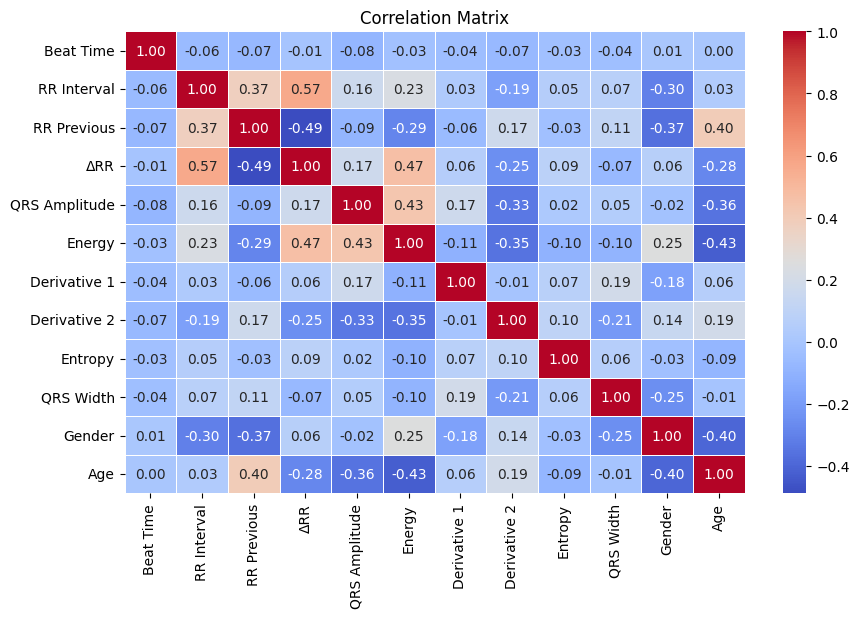

In [20]:
corr_matrix = df_clean.drop(columns=["Label", "Record", "Class", "Dominant Frequency", "Medications (Y/N)"]).corr()


plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

**Analysis: Correlation matrix**

We can see that **the higher correlation values are in RR related variables**.

Additionally, we can see correlation between Energy & ΔRRV and Energy & QRS Amplitude. On the other hand, we can see inverse correlation between Age & Energy.

**Boxplots: Distributions by Class**

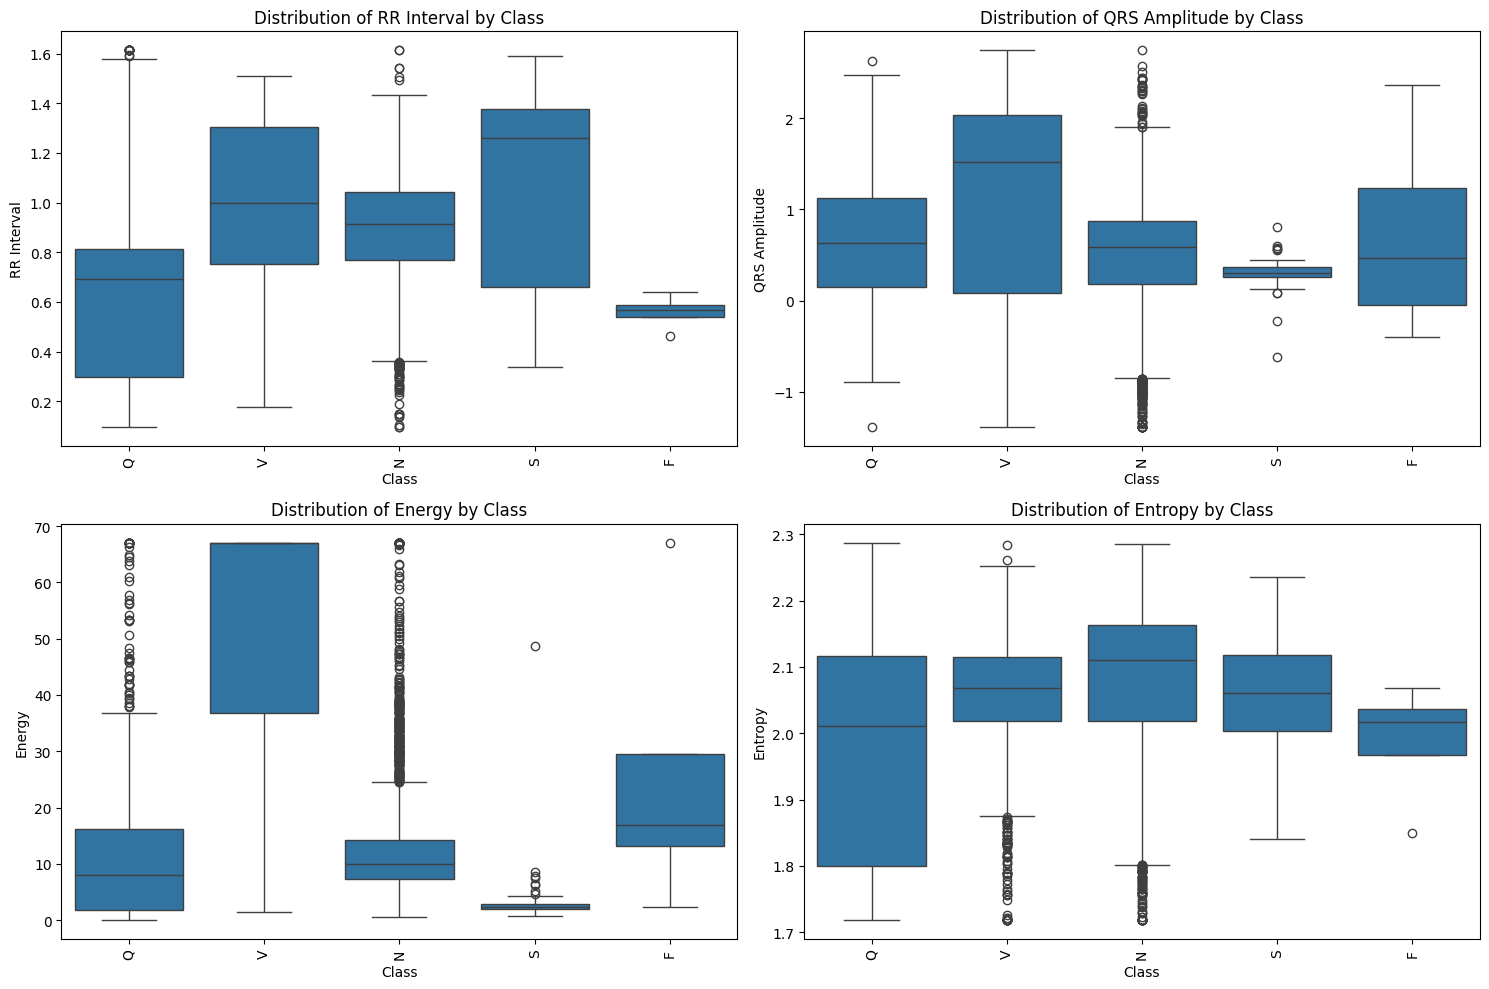

In [23]:
# Enhanced visualization: boxplots to compare features between classes

# Select key features to visualize
key_features = ['RR Interval', 'QRS Amplitude', 'Energy', 'Entropy']

# Create boxplots for each feature by class
plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='Class', y=feature, data=df_clean)
    plt.title(f'Distribution of {feature} by Class')
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

This set of boxplots shows the distribution of four key ECG features—*RR Interval, QRS Amplitude, Energy, and Entropy*—across different heartbeat classes.

Distinctive patterns can be observed: for instance, class 'S' has a higher RR Interval, while class 'V' shows wider variation in Energy and QRS Amplitude. These differences suggest that these features may be useful for distinguishing between classes.

<Figure size 1000x800 with 0 Axes>

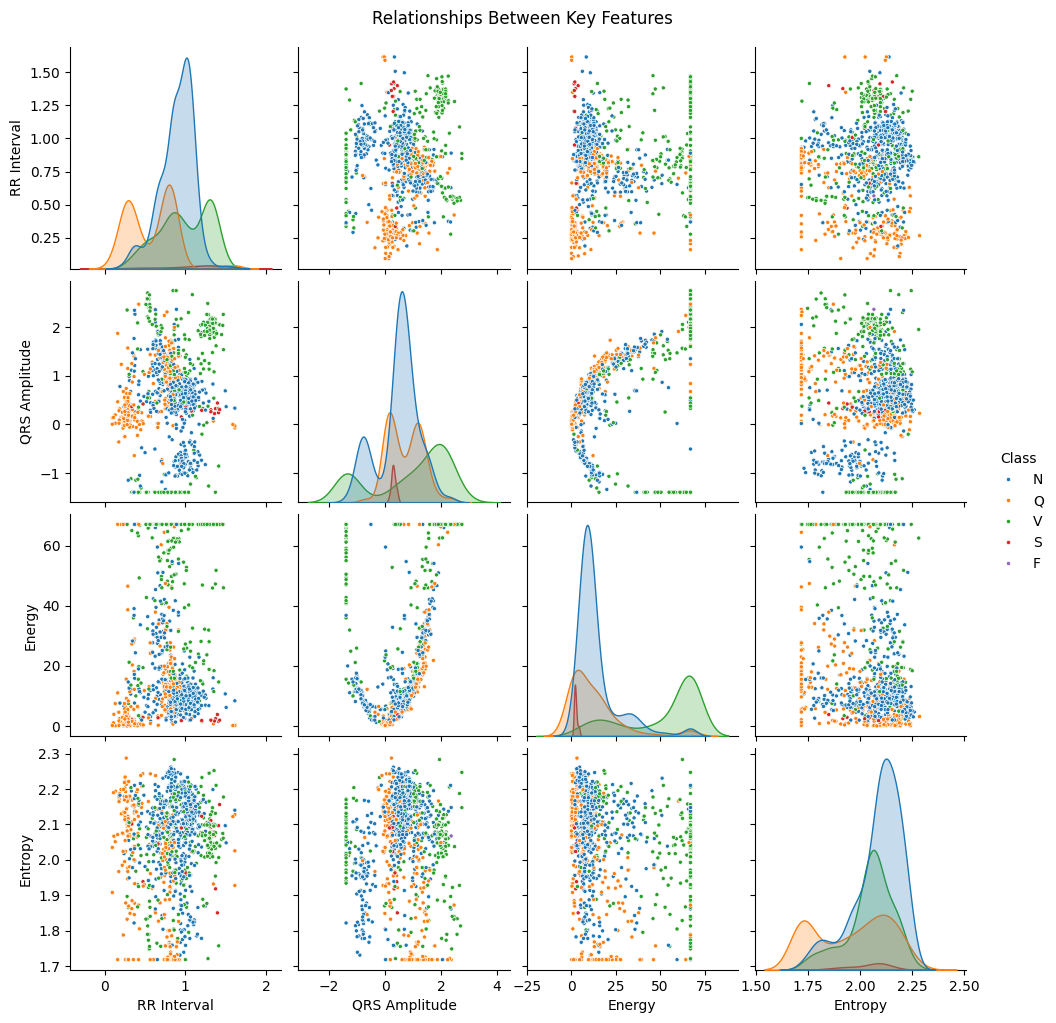

In [22]:
# Create pairplot for selected features
plt.figure(figsize=(10, 8))
sns.pairplot(df_clean.sample(1000), # Sample for better visualization
             vars=key_features,
             hue='Class',
             diag_kind='kde',
             markers='.')
plt.suptitle('Relationships Between Key Features', y=1.02)
plt.show()

The pairplot visualizes pairwise relationships between the four features, color-coded by class. It reveals clustering trends—for example, class 'N' tends to cluster around moderate RR and Entropy values, while class 'V' appears more dispersed in Energy and Amplitude.

Some nonlinear relationships between features are visible, especially between Energy and QRS Amplitude. The diagonal histograms further show the distribution differences per class.

# 3. **MACHINE LEARNING**

After the feature extraction and the exploratory analysis of the variables in our dataset, we can start our Machine Learning part.

As a first step, we will perform the train and test partition in the dataset.

#### 3.1 **Train/Test partition**

We remove the 'Label' and 'Record' variables from the X part, and we select 'Label' to be the Y.

In [27]:
# Select features and target variable
X = df_clean.drop(columns=['Label', 'Record', 'Class'])
y = df_clean['Class']
feature_names = X.columns

# Normalize the data (scale to standard values)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)
X_test = pd.DataFrame(X_test, columns=feature_names)

# Display results
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (3505, 14)
Test set: (877, 14)


We have 3505 records in the training set and 14 variables, and 877 and 14 in the test set.

#### 3.2 **Data balancing with SMOTE**

As mentioned during the data preprocessing, our data is not balanced, so we have to perform a data balancing with SMOTE technique.


https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/

In [28]:
from collections import Counter
from imblearn.over_sampling import SMOTE
import numpy as np

# Balance the classes using SMOTE (only on training set)
smote = SMOTE(random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Before resampling
before_resampling = Counter(y_train)
before_df = pd.DataFrame(list(before_resampling.items()), columns=["Class", "Count"])

# After resampling
after_resampling = Counter(y_resampled)
after_df = pd.DataFrame(list(after_resampling.items()), columns=["Class", "Count"])

print("Before Resampling:")
print(before_df.to_string(index=False))

print("\nAfter Resampling:")
print(after_df.to_string(index=False))

X_resampled = pd.DataFrame(X_resampled, columns=feature_names)

Before Resampling:
Class  Count
    Q    920
    N   1703
    V    821
    S     58
    F      3

After Resampling:
Class  Count
    Q   1703
    N   1703
    V   1703
    S   1703
    F   1703


It is now visible that our data has been balanced, resulting in 1703 beats in every class.

### 3.3 **Data training and testing (RANDOM FOREST, SVM & KNN)**

In this step, we train our models with Random Forest, SVM (Support Vector Machines) and KNN (K-Nearest Neighbours) to evaluate them and obtain the metrics to compare them and see which one gives better performance for our dataset.

In [29]:
# ML Models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM (RBF Kernel)": SVC(kernel='rbf', probability=True, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
}

results = {}

for name, model in models.items():
    print(f"\n--- Training and evaluating: {name} ---")

    # Train
    model.fit(X_resampled, y_resampled)

    # Predict (Test)
    y_pred = model.predict(X_test)

    # Obtain and save metrics
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=1)
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(report)

    results[name] = {
        "model": model,
        "accuracy": acc,
        "classification_report": report,
        "confusion_matrix": cm,
        "classes": model.classes_
    }


# Print the best model
best_model = max(results.items(), key=lambda x: x[1]['accuracy'])
print(f"\nBest model: {best_model[0]} with accuracy {best_model[1]['accuracy']:.4f}")


--- Training and evaluating: Random Forest ---
Accuracy: 0.9669
Classification Report:
              precision    recall  f1-score   support

           F       1.00      0.00      0.00         1
           N       0.97      0.98      0.98       426
           Q       0.96      0.98      0.97       230
           S       1.00      1.00      1.00        15
           V       0.95      0.93      0.94       205

    accuracy                           0.97       877
   macro avg       0.98      0.78      0.78       877
weighted avg       0.97      0.97      0.97       877


--- Training and evaluating: SVM (RBF Kernel) ---
Accuracy: 0.9475
Classification Report:
              precision    recall  f1-score   support

           F       1.00      0.00      0.00         1
           N       0.97      0.95      0.96       426
           Q       0.93      0.93      0.93       230
           S       0.79      1.00      0.88        15
           V       0.93      0.96      0.94       205

    ac

# 4. **RESULTS ANALYSIS**

**Metrics description**

*   **Precision**: The proportion of correct positive predictions (TP / (TP +
FP)). It tells how many selected items are actually relevant.

*   **Recall**: The proportion of actual positives correctly identified (TP / (TP + FN)). It tells how many relevant items were selected.

*   **F1-score**: The harmonic mean of precision and recall. A balance between the two.

*   **Support**: The number of actual instances of each class in the test data.

*   **Accuracy**: The overall proportion of correct predictions (total correct / total predictions).

*   **Macro avg**: The unweighted average of each metric across all classes (treats all classes equally).

*   **Weighted avg**: The average of each metric across classes, weighted by the number of instances (gives more weight to frequent classes).

##### 4.1. **Random Forest**

**Accuracy**: 0.9669

Per-class performance:

*  Class F: Only one test instance, which the model failed to identify (recall = 0.00). Despite this, it avoided false positives (precision = 1.00).
*  Classes N and Q: Excellent performance, with precision, recall, and f1-scores around or above 0.97.
*  Class S: Perfect performance (f1-score = 1.00), despite its small support (15 samples).
*  Class V: Consistent and reliable, with f1-score of 0.94.

Macro & weighted averages:

Macro f1-score drops slightly (0.78) due to class F’s misclassification, but

Weighted f1-score is high (0.97), showing strong overall performance across frequent classes.

Conclusion: Best-performing model. Random Forest maintains high performance across all major classes, and even though it missed the single class F instance, its overall generalization and class balance handling are excellent.

##### 4.2. **SVM (Support Vector Machines, with RBF Kernel)**

**Accuracy**: 0.9475

Per-class performance:

*  Class F: One test instance, missed by the model (recall = 0.00), but no false positives (precision = 1.00).
*  Classes N, Q, V: Solid scores, especially for common classes.
*  Class S: Perfect recall (1.00), but lower precision (0.79), indicating some false positives.

Macro & weighted averages:

Macro f1-score: 0.74 — lowered by the class F miss and lower precision on class S.

Weighted f1-score: 0.95 — still strong due to dominant classes.

Conclusion: The SVM model performs well on the majority of the data but shows some weakness with underrepresented classes like F and S. Its overall accuracy and precision are solid, though slightly below Random Forest.

##### 4.3. **KNN (K-Nearest Neighbors)**

**Accuracy**: 0.9430

Per-class performance:

*  Class F: Again, missed completely by the model (recall = 0.00), though with no false positives.
*  Class S: Perfect recall (1.00), but low precision (0.60), suggesting frequent misclassification of other classes as S.
*  Classes N, Q, V: Consistent performance similar to SVM.

Macro & weighted averages:

Macro f1-score: Lowest at 0.72 — due to poor handling of minority classes.

Weighted f1-score: 0.94 — still reflects good major-class accuracy.

Conclusion: KNN shows reliable results for frequent classes but performs worse than Random Forest and SVM on rare or borderline cases. Misclassifications in low-support classes affect the macro metrics more significantly.

# 5. **MODEL EXPLAINABILITY**

Class 0 corresponds to label: F
Class 1 corresponds to label: N
Class 2 corresponds to label: Q
Class 3 corresponds to label: S
Class 4 corresponds to label: V


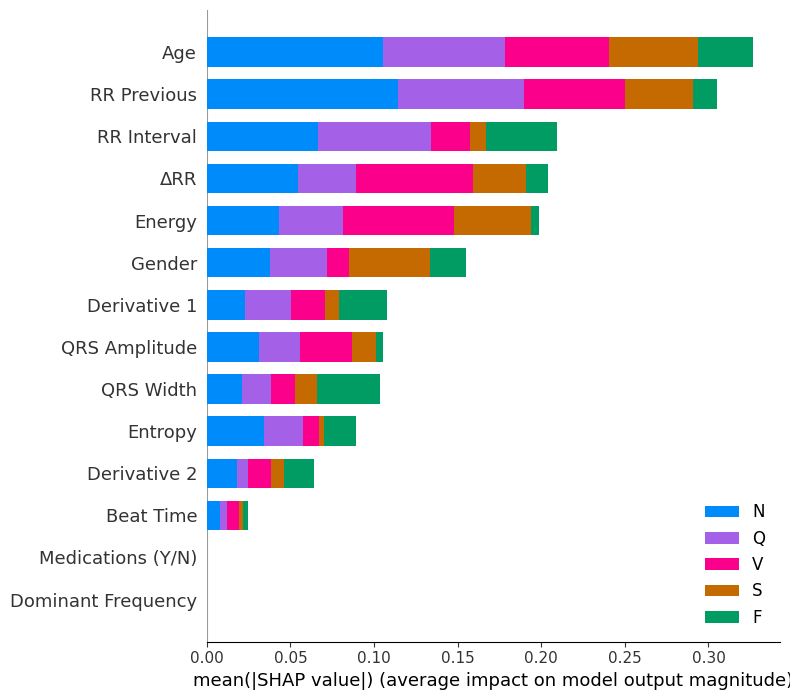

In [30]:
import shap

# SHAP explainability - only with the best model (Random Forest in this case)
best_model_name = best_model[0]
best_model_object = best_model[1]['model']
class_names = best_model[1]['classes']  # Real class names ('N', 'S', etc.)

for i, class_name in enumerate(class_names):
    print(f"Class {i} corresponds to label: {class_name}")

explainer = shap.TreeExplainer(best_model_object)
shap_values = explainer(X_test)

# Visualization
shap.summary_plot(shap_values, X_test, plot_type="bar", class_names=class_names)

This bar plot shows the mean absolute SHAP value for each feature, indicating their average impact on the model output magnitude across all classes (N, Q, V, S, F).
Key observations:

*  **Age**: Has the highest overall impact on model predictions
*  RR Previous: Second most important feature (previous RR interval)
*  RR Interval: Third most important feature
*  ΔRR: Delta RR has moderate impact
*  Energy: Moderate impact
*  Gender: Less impact than the top features but still significant
*  ECG Morphology Features (Derivative 1, QRS Amplitude, QRS Width, Entropy): Have lower but still measurable impact
*  Derivative 2 and Beat Time: Minimal impact
*  Medications and Dominant Frequency: Appear to have negligible impact

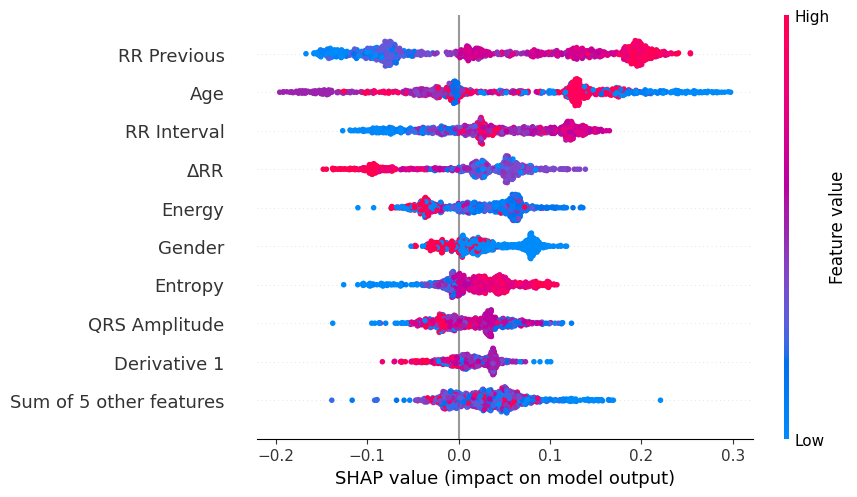

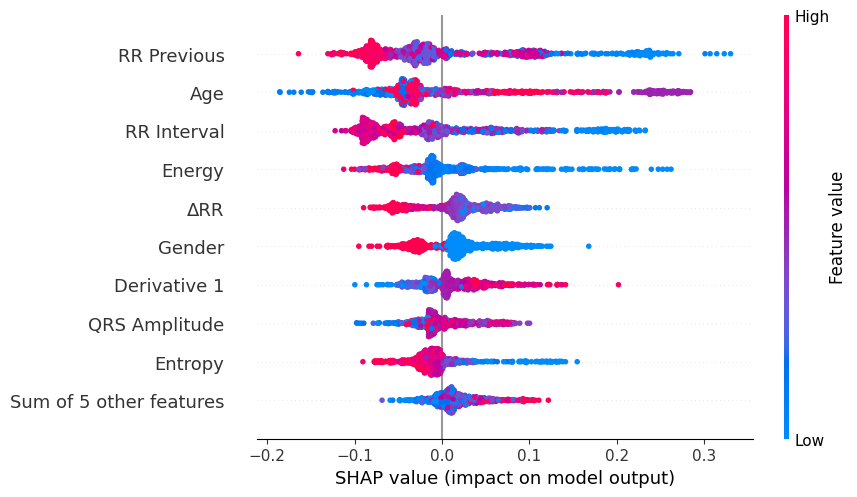

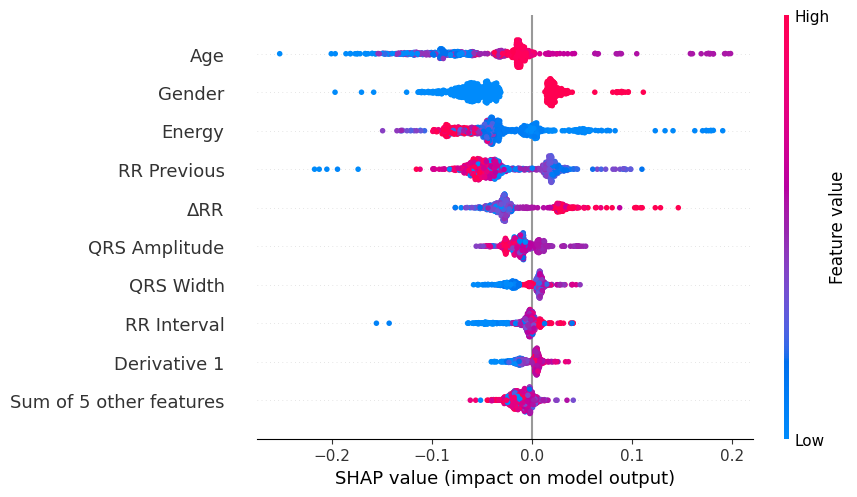

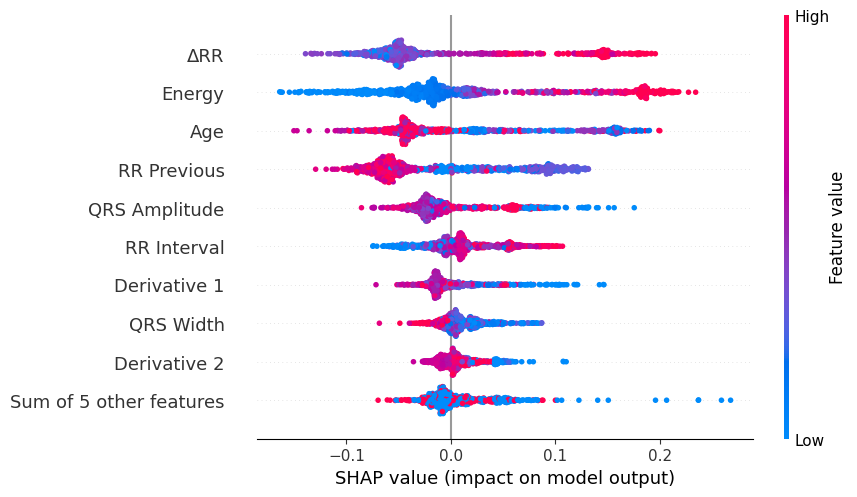

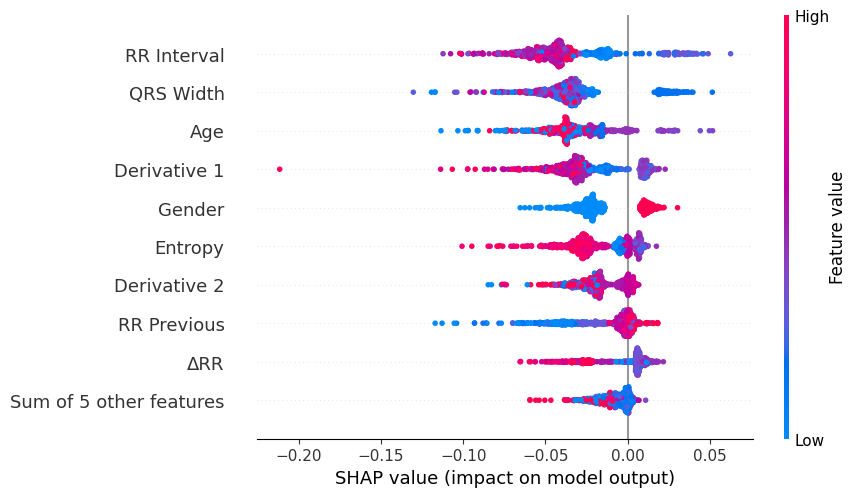

In [35]:
# For class "1" = 'N' (Normal beat)
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
shap.plots.beeswarm(shap_values[..., 1])
plt.savefig('/content/drive/My Drive/TFM/shap_class_N.png', bbox_inches='tight')  # Save the plot as a PNG image
plt.close()  # Close the current figure

# For class "2" = 'Q' (Unknown beat)
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
shap.plots.beeswarm(shap_values[..., 2])
plt.savefig('/content/drive/My Drive/TFM/shap_class_Q.png', bbox_inches='tight')  # Save the plot as a PNG image
plt.close()

# For class "3" = 'S' (Supraventricular beat)
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
shap.plots.beeswarm(shap_values[..., 3])
plt.savefig('/content/drive/My Drive/TFM/shap_class_S.png', bbox_inches='tight')  # Save the plot as a PNG image
plt.close()

# For class "4" = 'V' (Ventricular beat)
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
shap.plots.beeswarm(shap_values[..., 4])
plt.savefig('/content/drive/My Drive/TFM/shap_class_V.png', bbox_inches='tight')  # Save the plot as a PNG image
plt.close()

# For class "0" = 'F' (Fusion beat)
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
shap.plots.beeswarm(shap_values[..., 0])
plt.savefig('/content/drive/My Drive/TFM/shap_class_F.png', bbox_inches='tight')  # Save the plot as a PNG image
plt.close()

These plots show detailed SHAP value distributions for each feature across different classes. Each point represents a single sample, with color indicating feature value (red = high, blue = low) and position showing the SHAP impact.

*  **Class N - Normal Beat**

RR Previous: High values (red) generally push predictions toward normal beats

Age: Shows complex relationship - both high and low values impact predictions differently

RR Interval: Mixed impact with clustering around middle values

ΔRR: Low values (blue) tend to suggest normal beats

*  **Class Q - Unknown Beat**

RR Previous: Low values (blue) push toward this classification

Age: More complex distribution, but shows significant impact

RR Interval: Both high and low values can influence this class

Energy: Lower values (blue) tend to suggest unknown beats

*  **Class V - Ventricular Beat**

Age: High values (red) seem to push away from ventricular classification

Gender: Shows clear separation with higher values (likely male) being more predictive

Energy: Higher values seem associated with ventricular beats

RR Previous: Lower values (blue) have some association with ventricular beats

*  **Class S - Supraventricular Beat**

ΔRR: Very strong impact with high values (red) strongly indicative of supraventricular beats

Energy: High values have positive impact

Age: Shows complex relationship

RR Previous: Lower values (blue) have negative impact

*  **Class F - Fusion Beat**

RR Interval: Strongly negative impact (pushing toward fusion beat when low)

QRS Width: Low values (blue) have negative impact

Age: Mixed impact with some clustering

Gender: Clear separation between values

RR Previous: Higher values (red) push toward fusion beat classification


#### **Overall Insights**

Temporal features (RR intervals and their derivatives) are consistently the most important predictors across classes.

Demographic features (Age, Gender) have significant impact, with Age being particularly important.

Signal morphology features (QRS Amplitude, QRS Width, Entropy) are more important for specific classes than others.

Each ECG beat class has a unique "signature" of feature relationships:

Normal beats: Strongly influenced by regular RR intervals

Unknown beats: Associated with irregular patterns in RR Previous

Ventricular beats: Strongly associated with gender and energy

Supraventricular beats: Highly dependent on ΔRR changes

Fusion beats: Strongly associated with shorter RR intervals


The model appears to be leveraging clinically relevant factors, as the importance of features aligns with known ECG interpretation principles where timing intervals, age, and signal characteristics help differentiate beat types.

In [47]:
!find /content/drive -name "main.ipynb" -type f

In [48]:
!jupyter nbconvert '/content/drive/My Drive/TFM/main.ipynb' --to html --output='/content/drive/My Drive/TFM/main'
print("Saved as 'main.html'")

[NbConvertApp] Converting notebook /content/drive/My Drive/TFM/main.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 11 image(s).
[NbConvertApp] Writing 2310674 bytes to /content/drive/My Drive/TFM/main.html
Saved as 'main.html'
